## Import Libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report
from tqdm import tqdm
import timm
import numpy as np
from scipy.stats import skew, kurtosis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

## Data Loading

In [4]:
from datasets import load_dataset
ds = load_dataset("Falah/Alzheimer_MRI")

## Data Analysis

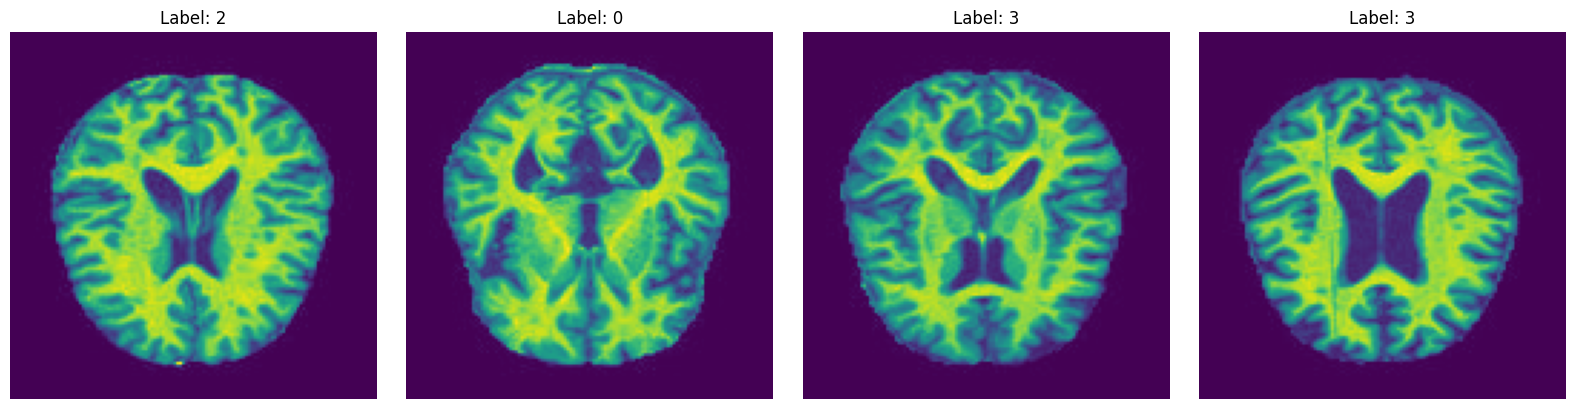

In [5]:
import matplotlib.pyplot as plt

# Display 4 sample images from the "train" dataset in a single row
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns
for i in range(4):  # Display 4 sample images
    sample = ds["train"][i]
    image = sample["image"]
    label = sample["label"]
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# !pip install ts2vg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 5.1 MB/s eta 0:00:00a 0:00:01






Processing all images:   0%|          | 6/6400 [05:07<91:06:34, 51.30s/it]














































































































































































KeyboardInterrupt: 

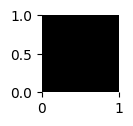

In [5]:
import os
import shutil
from pathlib import Path

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from ts2vg import NaturalVG
from datasets import load_dataset
from PIL import Image

# ─── SETTINGS ───────────────────────────────────────────────────────
DATASET_NAME = "Falah/Alzheimer_MRI"
OUTPUT_ROOT  = Path("/home/mhs/thesis/visibility_graph")  # where to save VG images
SAMPLE_SIZE  = 500       # max nodes per visibility graph
FIGSIZE      = (1, 1)
DPI          = 300
# ─── GRAPH SETTINGS ─────────────────────────────────────────────────
NODE_COLOR   = (0.695, 0.746, 0.0273, 1)
EDGE_COLOR   = (0.695, 0.746, 0.0273, 0.25)

graph_opts = {
    "with_labels": False,
    "node_size":   0.5,
    "node_color":  [NODE_COLOR],
    "edge_color":  [EDGE_COLOR],
}

def gen_vg(img_np: np.ndarray, sample_size=SAMPLE_SIZE) -> nx.Graph:
    """Build a Natural Visibility Graph from a flattened time series."""
    flat = img_np.flatten()
    if flat.size > sample_size:
        idx = np.linspace(0, flat.size - 1, sample_size, dtype=int)
        ts  = flat[idx]
    else:
        ts = flat
    nvg = NaturalVG()
    nvg.build(ts)
    return nvg.as_networkx()

def save_graph(G: nx.Graph, save_path: Path):
    """Render G and write to save_path as a PNG."""
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_facecolor("black")
    for spine in ax.spines.values():
        spine.set_visible(False)

    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx(G, pos=pos, **graph_opts)

    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=DPI, bbox_inches="tight", pad_inches=0, facecolor="black")
    plt.close(fig)

def main():
    # 1. Load your dataset
    ds = load_dataset(DATASET_NAME)
    # grab class names once
    class_names = ds["train"].features["label"].names

    # 2. (Re)create output directory
    if OUTPUT_ROOT.exists():
        shutil.rmtree(OUTPUT_ROOT)
    OUTPUT_ROOT.mkdir(parents=True)

    # 3. Iterate splits & samples
    total = sum(len(split) for split in ds.values())
    pbar = tqdm(total=total, desc="Processing all images")

    for split_name, split_ds in ds.items():
        for idx, example in enumerate(split_ds):
            # 3a. Get PIL image, convert to grayscale array
            pil_img = example["image"].convert("L")
            img_np  = np.array(pil_img)

            # 3b. Build VG
            G = gen_vg(img_np)

            # 3c. Determine save path: e.g. visibility_graph/train/AD/000123.png
            label_str = class_names[example["label"]]
            out_subdir = OUTPUT_ROOT / split_name / label_str
            save_fname = f"{idx:06d}.png"
            save_path  = out_subdir / save_fname

            # 3d. Render & save
            save_graph(G, save_path)
            pbar.update(1)

    pbar.close()
    print(f"Done! Processed {total} images into visibility graphs at {OUTPUT_ROOT}")

if __name__ == "__main__":
    main()

In [20]:
import numpy as np
from scipy.stats import skew, kurtosis
from PIL import Image

# ——— Manual GLCM implementation with overflow‐safe bins ———
def compute_glcm_features(arr, levels=8):
    # make sure min_val/max_val are Python scalars, not uint8
    min_val = int(arr.min())
    max_val = int(arr.max())
    # now no overflow when adding 1
    bins = np.linspace(min_val, max_val + 1, levels + 1)

    # quantize to 0…levels-1, then clip
    arr_q = np.digitize(arr, bins) - 1
    arr_q = np.clip(arr_q, 0, levels - 1)

    H, W = arr_q.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # horizontal co-occurrences
    for i in range(H):
        for j in range(W - 1):
            a = arr_q[i, j]
            b = arr_q[i, j + 1]
            glcm[a, b] += 1

    # symmetrize
    glcm = glcm + glcm.T

    total = glcm.sum()
    P = glcm / total if total > 0 else glcm

    i_inds, j_inds = np.indices(P.shape)
    contrast      = ((i_inds - j_inds)**2 * P).sum()
    dissimilarity = (np.abs(i_inds - j_inds) * P).sum()
    homogeneity   = (P / (1.0 + np.abs(i_inds - j_inds))).sum()
    ASM           = (P**2).sum()
    energy        = np.sqrt(ASM)

    mu_i    = (i_inds * P).sum()
    mu_j    = (j_inds * P).sum()
    sigma_i = np.sqrt(((i_inds - mu_i)**2 * P).sum())
    sigma_j = np.sqrt(((j_inds - mu_j)**2 * P).sum())

    denom = sigma_i * sigma_j
    correlation = (((i_inds - mu_i)*(j_inds - mu_j) * P).sum()) / denom \
                  if denom > 0 else 0

    return contrast, dissimilarity, homogeneity, energy, correlation, ASM

# ——— Radiomics feature extractor ———
def extract_radiomics(pil_img):
    arr = np.array(pil_img, dtype=np.float64)
    if arr.ndim == 3:
        arr = arr.mean(axis=2)          # RGB → gray
    mn, mx = arr.min(), arr.max()
    arr = (arr - mn) / (mx - mn) if mx > mn else arr

    # first‐order
    mean_intensity = arr.mean()
    std_intensity  = arr.std()
    skewness       = skew(arr.flatten())
    kurt_val       = kurtosis(arr.flatten())

    # texture via GLCM (8 levels)
    uint8_img = (arr * 255).astype(np.uint8)
    glcm_feats = compute_glcm_features(uint8_img, levels=8)

    # frequency
    fft_mag   = np.abs(np.fft.fftshift(np.fft.fft2(arr)))
    freq_mean = fft_mag.mean()
    freq_std  = fft_mag.std()

    return [
        mean_intensity, std_intensity, skewness, kurt_val,
        *glcm_feats,   # contrast, dissimilarity, homogeneity, energy, correlation, ASM
        freq_mean, freq_std
    ]

# ——— Example on your HuggingFace dataset ———
if __name__ == "__main__":
    # assume `ds` is already loaded; e.g. via `datasets.load_dataset(...)`
    s = ds["train"][0]
    img = s["image"]    # PIL.Image

    arr = np.array(img)
    print(f"Image shape: {arr.shape}, dtype: {arr.dtype}")
    print(f"Value range: {arr.min()}–{arr.max()}")

    feature_names = [
        "mean_intensity","std_intensity","skewness","kurtosis",
        "contrast","dissimilarity","homogeneity","energy",
        "correlation","ASM","freq_mean","freq_std"
    ]
    feats = extract_radiomics(img)

    print("\nRadiomic features:")
    for name, val in zip(feature_names, feats):
        print(f" • {name}: {val:.4f}")


Image shape: (128, 128), dtype: uint8
Value range: 0–157

Radiomic features:
 • mean_intensity: 0.3008
 • std_intensity: 0.3447
 • skewness: 0.5516
 • kurtosis: -1.3500
 • contrast: 0.3701
 • dissimilarity: 0.2848
 • homogeneity: 0.8708
 • energy: 0.5181
 • correlation: 0.9716
 • ASM: 0.2684
 • freq_mean: 9.6906
 • freq_std: 57.7488


## Feature Extraction

In [21]:
import numpy as np
from scipy.stats import skew, kurtosis
from tqdm import tqdm

# ——— 1) Manual GLCM for distance=1, angle=0 ———
def compute_glcm_features(arr, levels=8):
    # 1. Get clean Python ints for min/max so +1 can't overflow
    min_val = int(arr.min())
    max_val = int(arr.max())

    # 2. Build bins from min…max+1
    bins = np.linspace(min_val, max_val + 1, levels + 1)

    # 3. Digitize → 0…levels, then clip to 0…levels-1
    arr_q = np.digitize(arr, bins) - 1
    arr_q = np.clip(arr_q, 0, levels - 1)

    H, W = arr_q.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # 4. Count horizontal co-occurrences
    for i in range(H):
        for j in range(W - 1):
            a = arr_q[i, j]
            b = arr_q[i, j + 1]
            glcm[a, b] += 1

    # 5. Symmetrize & normalize
    glcm = glcm + glcm.T
    total = glcm.sum()
    P = glcm / total if total > 0 else glcm

    # 6. Precompute indices
    i_inds, j_inds = np.indices(P.shape)

    # 7. Haralick features
    contrast      = ((i_inds - j_inds)**2 * P).sum()
    dissimilarity = (np.abs(i_inds - j_inds) * P).sum()
    homogeneity   = (P / (1.0 + np.abs(i_inds - j_inds))).sum()
    ASM           = (P**2).sum()
    energy        = np.sqrt(ASM)

    mu_i    = (i_inds * P).sum()
    mu_j    = (j_inds * P).sum()
    sigma_i = np.sqrt(((i_inds - mu_i)**2 * P).sum())
    sigma_j = np.sqrt(((j_inds - mu_j)**2 * P).sum())

    denom = sigma_i * sigma_j
    correlation = (((i_inds - mu_i) * (j_inds - mu_j) * P).sum()) / denom \
                  if denom > 0 else 0

    return contrast, dissimilarity, homogeneity, energy, correlation, ASM

# ——— 2) Full radiomics extractor ———
def extract_radiomics(pil_img):
    arr = np.array(pil_img, dtype=np.float64)
    if arr.ndim == 3:
        arr = arr.mean(axis=2)

    # normalize to [0,1]
    mn, mx = arr.min(), arr.max()
    arr = (arr - mn) / (mx - mn) if mx > mn else arr

    # first-order
    mean_intensity = arr.mean()
    std_intensity  = arr.std()
    skewness       = skew(arr.flatten())
    kurt_val       = kurtosis(arr.flatten())

    # texture via GLCM (8 levels)
    gray8 = (arr * 255).astype(np.uint8)
    glcm_feats = compute_glcm_features(gray8, levels=8)

    # frequency-domain
    fft_mag   = np.abs(np.fft.fftshift(np.fft.fft2(arr)))
    freq_mean = fft_mag.mean()
    freq_std  = fft_mag.std()

    return [
        mean_intensity,
        std_intensity,
        skewness,
        kurt_val,
        *glcm_feats,   # contrast, diss, homogeneity, energy, corr, ASM
        freq_mean,
        freq_std
    ]

# ——— 3) Build and save train/test radiomics sets ———
train_feats, train_labels = [], []
for item in tqdm(ds['train'], desc='Extracting train radiomics'):
    train_feats.append(extract_radiomics(item['image']))
    train_labels.append(item['label'])
train_feats = np.array(train_feats, dtype=np.float64)
train_labels = np.array(train_labels)

test_feats, test_labels = [], []
for item in tqdm(ds['test'], desc='Extracting test radiomics'):
    test_feats.append(extract_radiomics(item['image']))
    test_labels.append(item['label'])
test_feats = np.array(test_feats, dtype=np.float64)
test_labels = np.array(test_labels)

# Save for downstream use
np.savez(
    'radiomics_dataset.npz',
    X_train=train_feats, y_train=train_labels,
    X_test=test_feats,  y_test=test_labels
)

print("Train X:", train_feats.shape, "Train y:", train_labels.shape)
print("Test  X:", test_feats.shape,  "Test  y:",  test_labels.shape)


Extracting test radiomics: 100%|██████████| 1280/1280 [00:06<00:00, 203.51it/s]

Train X: (5120, 12) Train y: (5120,)
Test  X: (1280, 12) Test  y: (1280,)


In [22]:
train_feats[0]

array([ 0.30081157,  0.34466129,  0.55158908, -1.34996086,  0.37007874,
        0.28481791,  0.87080463,  0.5181176 ,  0.9715865 ,  0.26844585,
        9.69060042, 57.7487617 ])

In [23]:
# 1) Standardize the radiomic features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_feats)
X_test_scaled  = scaler.transform(test_feats)

# 2) Fit PCA to retain 95% of the variance
pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3) (Optional) Inspect dimensionality reduction
print("Original feature count:", train_feats.shape[1])
print("Reduced feature count:", X_train_pca.shape[1])
print("Explained variance ratios:", pca.explained_variance_ratio_)

Original feature count: 12
Reduced feature count: 3
Explained variance ratios: [0.42530424 0.37522462 0.16033024]


## RF on Image Features

In [24]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# --- 1) Load radiomic features ---
rad = np.load('radiomics_dataset.npz')
X_train_rad, y_train = rad['X_train'], rad['y_train']
X_test_rad,  y_test  = rad['X_test'],  rad['y_test']

# --- 2) Radiomics-only classifiers ---
# a) Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_rad, y_train)
y_pred_rf = rf_clf.predict(X_test_rad)
print("Random Forest on radiomics only:")
print("  Test Acc:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest on radiomics only:
  Test Acc: 0.7078125
              precision    recall  f1-score   support

           0       0.62      0.50      0.55       172
           1       0.83      0.33      0.48        15
           2       0.74      0.83      0.78       634
           3       0.68      0.63      0.65       459

    accuracy                           0.71      1280
   macro avg       0.72      0.57      0.62      1280
weighted avg       0.70      0.71      0.70      1280



## CNN on Images

In [25]:
# —————————————————————————————————————————————
# 2) Simple CNN on images
# —————————————————————————————————————————————

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

class AlzheimerDataset(Dataset):
    def __init__(self, hf_dataset, split='train', transform=None):
        self.data = hf_dataset[split]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

# Shared image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1) if x.size(0)==1 else x),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# DataLoaders
train_ds = AlzheimerDataset(ds, 'train', transform=transform)
test_ds  = AlzheimerDataset(ds, 'test',  transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(set(ds['train']['label']))

# Define a small CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        # assuming input 224×224 → 28×28 after three 2×2 pools
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

cnn = SimpleCNN(num_classes=len(set(ds['train']['label']))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

# Training loop (10 epochs)
for epoch in range(10):
    cnn.train()
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        loss = criterion(cnn(imgs), lbls)
        loss.backward(); optimizer.step()

    # Eval on test set
    cnn.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            outs = cnn(imgs).argmax(dim=1).cpu().numpy()
            all_preds.extend(outs)
            all_labels.extend(lbls.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/10 — CNN Test Acc: {acc:.4f}")

print("\nFinal CNN classification report:")
print(classification_report(all_labels, all_preds))

Epoch 1/10 — CNN Test Acc: 0.5695
Epoch 2/10 — CNN Test Acc: 0.6352
Epoch 3/10 — CNN Test Acc: 0.6937
Epoch 4/10 — CNN Test Acc: 0.7773
Epoch 5/10 — CNN Test Acc: 0.8570
Epoch 6/10 — CNN Test Acc: 0.9008
Epoch 7/10 — CNN Test Acc: 0.9055
Epoch 8/10 — CNN Test Acc: 0.9266
Epoch 9/10 — CNN Test Acc: 0.9383
Epoch 10/10 — CNN Test Acc: 0.9641

Final CNN classification report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       172
           1       1.00      1.00      1.00        15
           2       0.98      0.97      0.97       634
           3       0.95      0.96      0.96       459

    accuracy                           0.96      1280
   macro avg       0.97      0.97      0.97      1280
weighted avg       0.96      0.96      0.96      1280



## Hyperparameters Tuning

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import transforms
# import optuna
# from sklearn.metrics import accuracy_score

# # —————————————————————————————————————————————
# # 1) Update SimpleCNN to take dropout_rate
# # —————————————————————————————————————————————
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes, dropout_rate=0.5):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(64,128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
#         )
#         # flatten 128×28×28 → 128*28*28
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128*28*28, 256),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_rate),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         return self.classifier(x)

# # —————————————————————————————————————————————
# # 2) Optuna objective
# # —————————————————————————————————————————————
# def objective(trial):
#     # 2.1 hyperparameters
#     lr           = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
#     dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.7)
#     batch_size   = trial.suggest_categorical("batch_size", [16, 32, 64])
#     momentum     = trial.suggest_float("momentum", 0.5, 0.99)

#     # 2.2 dataloaders
#     train_loader = DataLoader(
#         AlzheimerDataset(ds, 'train', transform=transform),
#         batch_size=batch_size, shuffle=True, num_workers=4
#     )
#     test_loader = DataLoader(
#         AlzheimerDataset(ds, 'test',  transform=transform),
#         batch_size=batch_size, shuffle=False, num_workers=4
#     )

#     # 2.3 model, loss, optimizer
#     model = SimpleCNN(num_classes, dropout_rate=dropout_rate).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#     # 2.4 train 10 epochs
#     for _ in range(10):
#         model.train()
#         for imgs, lbls in train_loader:
#             imgs, lbls = imgs.to(device), lbls.to(device)
#             optimizer.zero_grad()
#             loss = criterion(model(imgs), lbls)
#             loss.backward()
#             optimizer.step()

#     # 2.5 evaluate
#     model.eval()
#     all_preds, all_labels = [], []
#     with torch.no_grad():
#         for imgs, lbls in test_loader:
#             imgs = imgs.to(device)
#             preds = model(imgs).argmax(dim=1).cpu().numpy()
#             all_preds.extend(preds)
#             all_labels.extend(lbls.numpy())

#     return accuracy_score(all_labels, all_preds)

# # —————————————————————————————————————————————
# # 3) Run Optuna study
# # —————————————————————————————————————————————
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

# print("Best accuracy:", study.best_value)
# print("Best hyperparameters:", study.best_trial.params)

## Hyper-tuned CNN Model

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report

# —————————————————————————————————————————————
# 1) Dataset & Transforms
# —————————————————————————————————————————————
class AlzheimerDataset(Dataset):
    def __init__(self, hf_dataset, split='train', transform=None):
        self.data = hf_dataset[split]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img   = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1) if x.size(0)==1 else x),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

train_ds = AlzheimerDataset(ds, split='train', transform=transform)
test_ds  = AlzheimerDataset(ds, split='test',  transform=transform)

# —————————————————————————————————————————————
# 2) Hyperparameters from Optuna
# —————————————————————————————————————————————
best_params = {
    'lr':           0.008644386904929458,
    'dropout_rate': 0.47313948885291207,
    'batch_size':   16,
    'momentum':     0.5015235591320732
}

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(set(ds['train']['label']))

train_loader = DataLoader(train_ds,
                          batch_size=best_params['batch_size'],
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)
test_loader  = DataLoader(test_ds,
                          batch_size=best_params['batch_size'],
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)

# —————————————————————————————————————————————
# 3) Define CNN with tuned dropout
# —————————————————————————————————————————————
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_p):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        # After three 2×2 pools: 224→112→56→28
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

cnn = SimpleCNN(num_classes=num_classes,
                dropout_p=best_params['dropout_rate']).to(device)

# —————————————————————————————————————————————
# 4) Loss / Optimizer
# —————————————————————————————————————————————
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),
                            lr=best_params['lr'],
                            momentum=best_params['momentum'])

# —————————————————————————————————————————————
# 5) Training loop
# —————————————————————————————————————————————
n_epochs = 10
for epoch in range(1, n_epochs+1):
    cnn.train()
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        loss = criterion(cnn(imgs), lbls)
        loss.backward()
        optimizer.step()

    cnn.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            preds = cnn(imgs).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(lbls.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch}/{n_epochs} — Test Acc: {acc:.4f}")

print("\nFinal classification report:")
print(classification_report(all_labels, all_preds))

Epoch 1/10 — Test Acc: 0.5094
Epoch 2/10 — Test Acc: 0.5352
Epoch 3/10 — Test Acc: 0.6141
Epoch 4/10 — Test Acc: 0.7375
Epoch 5/10 — Test Acc: 0.7516
Epoch 6/10 — Test Acc: 0.8594
Epoch 7/10 — Test Acc: 0.9375
Epoch 8/10 — Test Acc: 0.9523
Epoch 9/10 — Test Acc: 0.9625
Epoch 10/10 — Test Acc: 0.9781

Final classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       172
           1       1.00      1.00      1.00        15
           2       0.98      0.99      0.98       634
           3       0.97      0.97      0.97       459

    accuracy                           0.98      1280
   macro avg       0.99      0.98      0.98      1280
weighted avg       0.98      0.98      0.98      1280



## Further Hyper Tunning

In [ ]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision import transforms

# import optuna
# from optuna.pruners import MedianPruner
# from tqdm import tqdm

# # ------------------------------
# # 0) Assume `ds` is already loaded:
# #    a HuggingFace DatasetDict with 'train' and 'test' splits,
# #    each item having keys 'image' and 'label'.
# # ------------------------------

# # Number of classes from the HF metadata
# NUM_CLASSES = len(ds['train'].features['label'].names)

# # ------------------------------
# # 1) Custom Dataset wrapper
# # ------------------------------
# class AlzheimerDataset(Dataset):
#     def __init__(self, hf_dataset, split='train', transform=None):
#         self.data = hf_dataset[split]
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img = self.data[idx]['image']
#         lbl = self.data[idx]['label']
#         if self.transform:
#             img = self.transform(img)
#         return img, lbl

# # ------------------------------
# # 2) Transforms + train/val split
# # ------------------------------
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.repeat(3,1,1) if x.size(0) == 1 else x),
#     transforms.Resize((224,224)),
#     transforms.Normalize(mean=[0.485,0.456,0.406],
#                          std=[0.229,0.224,0.225])
# ])

# # Full training dataset and test dataset
# full_train = AlzheimerDataset(ds, split='train', transform=transform)
# test_ds    = AlzheimerDataset(ds, split='test',  transform=transform)

# # 80/20 train/validation split
# train_len = int(0.8 * len(full_train))
# val_len   = len(full_train) - train_len
# train_ds, val_ds = random_split(full_train, [train_len, val_len])

# def make_loader(dataset, batch_size, shuffle):
#     return DataLoader(
#         dataset,
#         batch_size=batch_size,
#         shuffle=shuffle,
#         num_workers=4,
#         pin_memory=True
#     )

# # ------------------------------
# # 3) Define the Optuna-powered CNN
# # ------------------------------
# class OptunaCNN(nn.Module):
#     def __init__(self, trial, num_classes, input_shape):
#         super().__init__()
#         self.convs = nn.ModuleList()
#         self.norms = nn.ModuleList()

#         in_ch = input_shape[0]
#         n_conv = trial.suggest_int('n_conv_layers', 1, 4)
#         for i in range(n_conv):
#             out_ch = trial.suggest_categorical(f"conv{i}_out", [16, 32, 64, 128])
#             k      = trial.suggest_int(f"conv{i}_k", 3, 7, step=2)
#             p      = trial.suggest_int(f"conv{i}_pad", 0, k // 2)
#             self.convs.append(nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p))

#             norm_t = trial.suggest_categorical(f"conv{i}_norm", ['none', 'batch', 'layer'])
#             if norm_t == 'batch':
#                 self.norms.append(nn.BatchNorm2d(out_ch))
#             elif norm_t == 'layer':
#                 self.norms.append(nn.GroupNorm(1, out_ch))
#             else:
#                 self.norms.append(None)

#             in_ch = out_ch

#         self.pool = nn.MaxPool2d(2)

#         # compute flattened size
#         with torch.no_grad():
#             x = torch.zeros(1, *input_shape)
#             for conv, norm in zip(self.convs, self.norms):
#                 x = conv(x)
#                 if norm: x = norm(x)
#                 x = F.relu(x)
#                 x = self.pool(x)
#             n_flat = x.numel()

#         # fully-connected layers
#         self.fcs = nn.ModuleList()
#         n_fc = trial.suggest_int('n_fc_layers', 1, 3)
#         in_feat = n_flat
#         for j in range(n_fc):
#             out_f = trial.suggest_int(f"fc{j}_units", 32, 512, step=32)
#             self.fcs.append(nn.Linear(in_feat, out_f))
#             in_feat = out_f

#         self.output    = nn.Linear(in_feat, num_classes)
#         self.dropout_p = trial.suggest_uniform('dropout', 0.0, 0.5)
#         self.act_name  = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu'])

#     def forward(self, x):
#         for conv, norm in zip(self.convs, self.norms):
#             x = conv(x)
#             if norm:
#                 x = norm(x)
#             if self.act_name == 'relu':
#                 x = F.relu(x)
#             elif self.act_name == 'leaky_relu':
#                 x = F.leaky_relu(x)
#             else:
#                 x = F.elu(x)
#             x = self.pool(x)

#         x = x.view(x.size(0), -1)
#         for fc in self.fcs:
#             x = fc(x)
#             if self.act_name == 'relu':
#                 x = F.relu(x)
#             elif self.act_name == 'leaky_relu':
#                 x = F.leaky_relu(x)
#             else:
#                 x = F.elu(x)
#             x = F.dropout(x, p=self.dropout_p, training=self.training)

#         return self.output(x)

# # ------------------------------
# # 4) Optuna objective function
# # ------------------------------
# def objective(trial):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # Suggest hyperparameters
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
#     lr         = trial.suggest_loguniform('lr', 1e-5, 1e-1)
#     opt_name   = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
#     epochs     = trial.suggest_int('epochs', 10, 50)
#     patience   = trial.suggest_int('patience', 3, 7)

#     # DataLoaders
#     train_loader = make_loader(train_ds, batch_size, shuffle=True)
#     val_loader   = make_loader(val_ds,   batch_size, shuffle=False)

#     # Build model
#     sample_img, _ = next(iter(train_loader))
#     input_shape   = sample_img.shape[1:]
#     model = OptunaCNN(trial, num_classes=NUM_CLASSES, input_shape=input_shape).to(device)

#     # Optimizer
#     if opt_name == 'Adam':
#         optimizer = optim.Adam(model.parameters(), lr=lr)
#     elif opt_name == 'RMSprop':
#         optimizer = optim.RMSprop(model.parameters(), lr=lr)
#     else:
#         momentum = trial.suggest_uniform('momentum', 0.5, 0.9)
#         optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#     criterion = nn.CrossEntropyLoss()
#     best_loss = float('inf')
#     no_improve = 0

#     for epoch in range(epochs):
#         model.train()
#         for imgs, lbls in train_loader:
#             imgs, lbls = imgs.to(device), lbls.to(device)
#             optimizer.zero_grad()
#             loss = criterion(model(imgs), lbls)
#             loss.backward()
#             optimizer.step()

#         # Validation
#         model.eval()
#         val_loss, correct, total = 0.0, 0, 0
#         with torch.no_grad():
#             for imgs, lbls in val_loader:
#                 imgs, lbls = imgs.to(device), lbls.to(device)
#                 outputs = model(imgs)
#                 val_loss += criterion(outputs, lbls).item()
#                 preds = outputs.argmax(dim=1)
#                 correct += (preds == lbls).sum().item()
#                 total += lbls.size(0)
#         avg_loss = val_loss / len(val_loader)

#         trial.report(avg_loss, epoch)
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#         if avg_loss < best_loss:
#             best_loss = avg_loss
#             no_improve = 0
#         else:
#             no_improve += 1
#             if no_improve >= patience:
#                 break

#     return best_loss

# # ------------------------------
# # 5) Run the Optuna study
# # ------------------------------
# if __name__ == "__main__":
#     study = optuna.create_study(direction="minimize", pruner=MedianPruner())
#     study.optimize(objective, n_trials=50)

#     print("Best trial:")
#     print(f"  Loss:   {study.best_value:.4f}")
#     print("  Params:")
#     for key, value in study.best_params.items():
#         print(f"    {key}: {value}")

## CNN + Other Models

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, classification_report

# —————————————————————————————————————————————
# 1) Dataset & Transforms (unchanged)
# —————————————————————————————————————————————
class AlzheimerDataset(Dataset):
    def __init__(self, hf_dataset, split='train', transform=None):
        self.data = hf_dataset[split]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img   = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1) if x.size(0)==1 else x),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

train_ds = AlzheimerDataset(ds, split='train', transform=transform)
test_ds  = AlzheimerDataset(ds, split='test',  transform=transform)

# —————————————————————————————————————————————
# 2) Hyperparameters (from Optuna)
# —————————————————————————————————————————————
best_params = {
    'lr':           0.008644386904929458,
    'dropout_rate': 0.47313948885291207,
    'batch_size':   16,
    'momentum':     0.5015235591320732
}

device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(set(ds['train']['label']))

train_loader = DataLoader(train_ds,
                          batch_size=best_params['batch_size'],
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)
test_loader  = DataLoader(test_ds,
                          batch_size=best_params['batch_size'],
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)

# —————————————————————————————————————————————
# 3) Define SE‐Block (channel attention)
# —————————————————————————————————————————————
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: (B, C, H, W)
        w = self.fc(x)          # (B, C, 1, 1)
        return x * w            # channel-wise reweight

# —————————————————————————————————————————————
# 4) Pretrained + Attention CNN
# —————————————————————————————————————————————
class PretrainedAttentionCNN(nn.Module):
    def __init__(self, num_classes, dropout_p):
        super().__init__()
        # 4.1 Load pretrained ResNet-18 and chop off its avgpool+fc
        backbone = models.resnet18(pretrained=True)
        for param in backbone.parameters():
            param.requires_grad = False    # freeze all layers

        self.features = nn.Sequential(*list(backbone.children())[:-2])
        # backbone output feature‐map has 512 channels

        # 4.2 Insert an SE block
        self.se = SEBlock(channels=512, reduction=16)

        # 4.3 Global pooling + your classifier head
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)       # shape (B,512,H/32,W/32)
        x = self.se(x)             # channel attention
        x = self.pool(x)           # shape (B,512,1,1)
        return self.classifier(x)

# Instantiate
model = PretrainedAttentionCNN(num_classes=num_classes,
                               dropout_p=best_params['dropout_rate']) \
         .to(device)

# —————————————————————————————————————————————
# 5) Loss / Optimizer
# —————————————————————————————————————————————
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=best_params['lr'],
                            momentum=best_params['momentum'])

# —————————————————————————————————————————————
# 6) Training loop (same as before)
# —————————————————————————————————————————————
n_epochs = 10
for epoch in range(1, n_epochs+1):
    model.train()
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        loss = criterion(model(imgs), lbls)
        loss.backward()
        optimizer.step()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            preds = model(imgs).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(lbls.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch}/{n_epochs} — Test Acc: {acc:.4f}")

print("\nFinal classification report:")
print(classification_report(all_labels, all_preds))

/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mhs/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:47<00:00, 991kB/s] 


Epoch 1/10 — Test Acc: 0.5656
Epoch 2/10 — Test Acc: 0.5844
Epoch 3/10 — Test Acc: 0.5836
Epoch 4/10 — Test Acc: 0.5922
Epoch 5/10 — Test Acc: 0.6117
Epoch 6/10 — Test Acc: 0.5922
Epoch 7/10 — Test Acc: 0.6109
Epoch 8/10 — Test Acc: 0.6156
Epoch 9/10 — Test Acc: 0.6125
Epoch 10/10 — Test Acc: 0.6359

Final classification report:
              precision    recall  f1-score   support

           0       0.44      0.19      0.27       172
           1       0.00      0.00      0.00        15
           2       0.76      0.71      0.74       634
           3       0.54      0.72      0.61       459

    accuracy                           0.64      1280
   macro avg       0.44      0.41      0.40      1280
weighted avg       0.63      0.64      0.62      1280



/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report

# —————————————————————————————————————————————
# 1) Dataset setup (reuse your ds and transforms)
# —————————————————————————————————————————————
class AlzheimerDataset(Dataset):
    def __init__(self, hf_dataset, split='train', transform=None):
        self.data = hf_dataset[split]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

# Image transforms (same as before)
fusion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1) if x.size(0)==1 else x),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = AlzheimerDataset(ds, 'train', transform=fusion_transform)
test_ds  = AlzheimerDataset(ds, 'test',  transform=fusion_transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

# —————————————————————————————————————————————
# 2) Define backbones for feature extraction
# —————————————————————————————————————————————
class ResNet50Feature(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        # Remove final fc, keep avgpool + flatten directly
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        return self.backbone(x)           # [B, 2048]

class SimpleCNNFeature(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        # After 3 pools on 224x224 → 28x28 spatial
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.features(x)
        return self.flatten(x)           # [B, 128*28*28]

# —————————————————————————————————————————————
# 3) Fusion model combining both feature streams
# —————————————————————————————————————————————
class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet_feat = ResNet50Feature()
        self.cnn_feat    = SimpleCNNFeature()
        # compute flattened size of SimpleCNNFeature outputs:
        example = torch.zeros(1,3,224,224)
        cnn_out_dim = self.cnn_feat(example).shape[1]

        # fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + cnn_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = self.resnet_feat(x)          # [B,2048]
        f2 = self.cnn_feat(x)             # [B,cnn_out_dim]
        fused = torch.cat([f1, f2], dim=1)
        return self.classifier(fused)

# —————————————————————————————————————————————
# 4) Instantiate model, loss, optimizer
# —————————————————————————————————————————————
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(set(ds['train']['label']))
model = FusionModel(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# —————————————————————————————————————————————
# 5) Training & evaluation loops
# —————————————————————————————————————————————
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outs = model(imgs)
            preds = outs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    return acc, report

# —————————————————————————————————————————————
# 6) Run full training
# —————————————————————————————————————————————
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    test_acc, test_report = evaluate(model, test_loader)
    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Acc: {test_acc:.4f}")

# Final evaluation
final_acc, final_report = evaluate(model, test_loader)
print(f"\nFinal Test Accuracy: {final_acc:.4f}\n")
print(final_report)

/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 — Train Loss: 0.7702, Train Acc: 0.6504 | Test Acc: 0.7852


/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Epoch 2/10 — Train Loss: 0.3125, Train Acc: 0.8871 | Test Acc: 0.9227


/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Epoch 3/10 — Train Loss: 0.1070, Train Acc: 0.9660 | Test Acc: 0.9336
Epoch 4/10 — Train Loss: 0.0918, Train Acc: 0.9715 | Test Acc: 0.9211
Epoch 5/10 — Train Loss: 0.0499, Train Acc: 0.9832 | Test Acc: 0.9523
Epoch 6/10 — Train Loss: 0.0435, Train Acc: 0.9850 | Test Acc: 0.9539
Epoch 7/10 — Train Loss: 0.0312, Train Acc: 0.9898 | Test Acc: 0.9586
Epoch 8/10 — Train Loss: 0.0271, Train Acc: 0.9893 | Test Acc: 0.9555
Epoch 9/10 — Train Loss: 0.0305, Train Acc: 0.9896 | Test Acc: 0.9523
Epoch 10/10 — Train Loss: 0.0377, Train Acc: 0.9885 | Test Acc: 0.9641

Final Test Accuracy: 0.9641

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       172
           1       1.00      0.73      0.85        15
           2       0.99      0.97      0.98       634
           3       0.93      0.99      0.96       459

    accuracy                           0.96      1280
   macro avg       0.97      0.90      0.93      1280
weighted avg       0.96      

## Pre-trained Models

In [38]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define dataset class
class AlzheimerDataset(Dataset):
    def __init__(self, dataset, split='train', transform=None):
        self.data = dataset[split]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transforms
# Define transforms with grayscale to RGB conversion
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Create datasets
train_dataset = AlzheimerDataset(ds, 'train', transform=transform)
test_dataset = AlzheimerDataset(ds, 'test', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet50 and modify for our task
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
num_classes = len(set(ds['train']['label']))
model = ResNet50Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


# Testing function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_acc, preds, labels = evaluate(model, test_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Acc: {test_acc:.2f}%')
    print('-' * 50)

# Final evaluation and classification report
test_acc, preds, labels = evaluate(model, test_loader)
print('\nTest Accuracy: {:.2f}%'.format(test_acc))
print('\nClassification Report:')
print(classification_report(labels, preds))

# Save the model
torch.save(model.state_dict(), 'alzheimer_resnet50.pth')

/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|██████████| 40/40 [00:02<00:00, 17.84it/s]


Epoch [1/10]
Train Loss: 0.8634, Train Acc: 60.29%
Test Acc: 51.88%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.08it/s]


Epoch [2/10]
Train Loss: 0.6940, Train Acc: 69.69%
Test Acc: 51.64%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.20it/s]


Epoch [3/10]
Train Loss: 0.4475, Train Acc: 82.21%
Test Acc: 78.36%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.09it/s]


Epoch [4/10]
Train Loss: 0.2722, Train Acc: 89.88%
Test Acc: 80.86%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.47it/s]


Epoch [5/10]
Train Loss: 0.1943, Train Acc: 93.20%
Test Acc: 81.25%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.21it/s]


Epoch [6/10]
Train Loss: 0.1250, Train Acc: 95.64%
Test Acc: 79.06%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.23it/s]


Epoch [7/10]
Train Loss: 0.1095, Train Acc: 95.94%
Test Acc: 93.12%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.85it/s]


Epoch [8/10]
Train Loss: 0.0760, Train Acc: 97.17%
Test Acc: 92.27%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.00it/s]


Epoch [9/10]
Train Loss: 0.0622, Train Acc: 97.91%
Test Acc: 89.84%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 18.12it/s]


Epoch [10/10]
Train Loss: 0.0448, Train Acc: 98.54%
Test Acc: 87.27%
--------------------------------------------------


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.94it/s]



Test Accuracy: 87.27%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       172
           1       0.50      0.93      0.65        15
           2       1.00      0.80      0.89       634
           3       0.77      0.98      0.86       459

    accuracy                           0.87      1280
   macro avg       0.80      0.89      0.82      1280
weighted avg       0.90      0.87      0.88      1280



In [ ]:
# # Detect device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # List of model names in timm
# model_names = [
#     'resnet50', 'resnet101', 'resnet152',
#     'inception_v3', 'inception_resnet_v2',
#     'vgg16', 'vgg19',
#     'efficientnet_b0', 'efficientnet_b7', 'efficientnet_v2_l',
#     'densenet201',
#     'mobilenetv3_large_100',
#     'nasnetalarge',
#     'xception',
#     'vit_base_patch16_224'   # Vision Transformer
# ]

# def get_model(name: str, num_classes: int) -> nn.Module:
#     """
#     Create a pre-trained model with its final classifier head replaced
#     to output `num_classes` logits.
#     """
#     # timm will take care of replacing the classifier head
#     model = timm.create_model(name, pretrained=True, num_classes=num_classes)
#     return model

# # Training function
# def train_epoch(model, loader, criterion, optimizer):
#     model.train()
#     running_loss = 0.0
#     correct = total = 0

#     for imgs, labels in tqdm(loader, desc='Train', leave=False):
#         imgs, labels = imgs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(imgs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * imgs.size(0)
#         preds = outputs.argmax(dim=1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

#     return running_loss / total, 100. * correct / total

# # Evaluation function
# def evaluate(model, loader):
#     model.eval()
#     correct = total = 0
#     all_preds, all_labels = [], []

#     with torch.no_grad():
#         for imgs, labels in tqdm(loader, desc='Test ', leave=False):
#             imgs, labels = imgs.to(device), labels.to(device)
#             outputs = model(imgs)
#             preds = outputs.argmax(dim=1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     return 100. * correct / total, all_preds, all_labels

# # Assume you already have train_loader and test_loader set up:
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, ...)
# # test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,...)

# num_classes = len(set(ds['train']['label']))  # or however you compute this
# criterion   = nn.CrossEntropyLoss()
# num_epochs  = 10

# for name in model_names:
#     print(f"\n=== Training {name} ===")
#     model     = get_model(name, num_classes).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#     best_acc = 0.0
#     for epoch in range(1, num_epochs+1):
#         train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
#         test_acc, _, _      = evaluate(model, test_loader)

#         print(f"[{name}] Epoch {epoch}/{num_epochs} "
#               f"— Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.1f}%, "
#               f"Test Acc: {test_acc:.1f}%")

#         # Save best
#         if test_acc > best_acc:
#             best_acc = test_acc
#             torch.save(model.state_dict(), f"{name}_best.pth")

#     # Final evaluation & report
#     test_acc, preds, labels = evaluate(model, test_loader)
#     print(f"\n{name} Final Test Accuracy: {test_acc:.2f}%")
#     from sklearn.metrics import classification_report
#     print(classification_report(labels, preds, digits=4))

#     # Optionally rename or archive the final model
#     torch.save(model.state_dict(), f"{name}_final.pth")